### Setup enviroments

#### Connect to google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#### Dataset path

In [2]:
img_path = "/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/whole sky images_augmentation3/"
mask_path = "/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/annotation_augmentation3/"

img_val_path = "/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/whole sky images_augmentation/"
mask_val_path = "/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/annotation_augmentation/"

In [3]:
!pip install -U -q segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 6.0 MB/s eta 0:00:00


#### Import library

In [4]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

In [5]:
import cv2
import numpy as np 
import matplotlib.pyplot as plt
import os
import glob
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.utils import normalize
from skimage.transform import resize
from tqdm.notebook import tqdm 
from keras.utils import to_categorical
from sklearn.utils import compute_class_weight
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from PIL import Image
import tensorflow as tf
import segmentation_models as sm
from keras import backend as K
import albumentations as A

Segmentation Models: using `tf.keras` framework.


### EDA

In [6]:
print("Number of dataset:", len(os.listdir(img_path)))
print("Number of ground truth:", len(os.listdir(mask_path)))

Number of dataset: 1268
Number of ground truth: 1297


image shape: (450, 480, 3)
masked shape: (450, 480, 3)


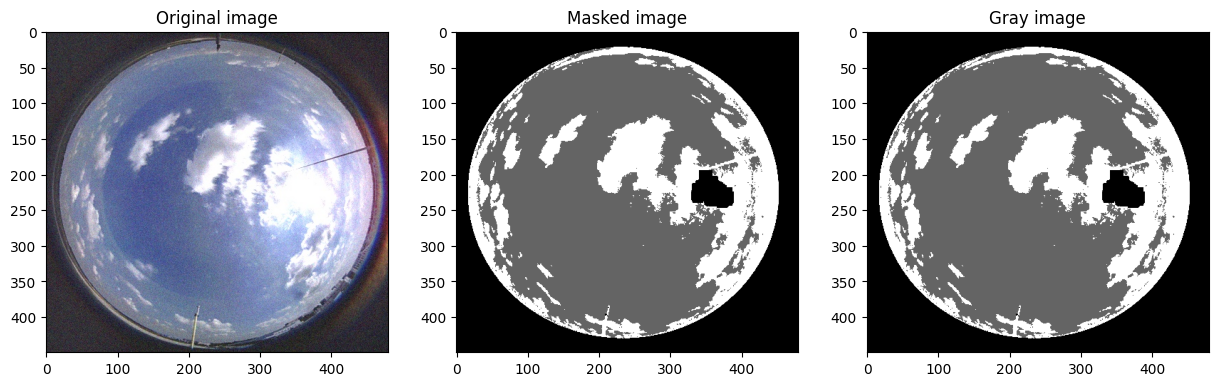

In [ ]:
ex_img = cv2.imread("/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/whole sky images_augmentation/ASC100-1006_001_augmented_2.png")
print("image shape:", ex_img.shape)

mask_ex_img = cv2.imread("/content/drive/MyDrive/senior/cloud segmentations/WSISEG-Database/annotation_augmentation/ASC100-1006_001_augmented_2.png")
print("masked shape:", mask_ex_img.shape)

f, (axz1, axz2, axz3) = plt.subplots(1,3, figsize=(15, 15))
axz1.imshow(cv2.cvtColor(ex_img, cv2.COLOR_BGR2RGB))
axz1.title.set_text("Original image")
axz2.imshow(mask_ex_img)
axz2.title.set_text("Masked image")
axz3.imshow(cv2.cvtColor(mask_ex_img, cv2.COLOR_BGR2GRAY), cmap="gray")
axz3.title.set_text("Gray image")
plt.show()

**Remark :** Not change mask extension filename becuase value on pixel change but if we do data augmentation it not effect to mask

In [ ]:
np.unique(mask_ex_img)

array([  0, 100, 255], dtype=uint8)

In [ ]:
resized_image = cv2.resize(mask_ex_img, (224, 224), 0, 0, interpolation = cv2.INTER_NEAREST)
resized_image.shape

(224, 224, 3)

In [ ]:
print(np.unique(np.array(resized_image)))

[  0 100 255]


In [ ]:
print(np.unique(np.array(ex_img)))

[  4   5   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23
  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41
  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59
  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77
  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95
  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113
 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131
 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149
 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 25

In [ ]:
ex_img

**remarks:**  These annotation images, cloud, clear sky and undefined area are marked with gray value 255, 100, 0 respectively.

### Data Preparation

In [ ]:
SIZE_X = 224
SIZE_Y = 224
n_classes = 3

In [ ]:
sorted(os.listdir(img_path))

['ASC100-1006_001_augmented_0.jpg',
 'ASC100-1006_001_augmented_1.jpg',
 'ASC100-1006_001_augmented_2.jpg',
 'ASC100-1006_001_augmented_3.jpg',
 'ASC100-1006_002_augmented_0.jpg',
 'ASC100-1006_002_augmented_1.jpg',
 'ASC100-1006_002_augmented_2.jpg',
 'ASC100-1006_002_augmented_3.jpg',
 'ASC100-1006_003_augmented_0.jpg',
 'ASC100-1006_003_augmented_1.jpg',
 'ASC100-1006_003_augmented_2.jpg',
 'ASC100-1006_003_augmented_3.jpg',
 'ASC100-1006_004_augmented_0.jpg',
 'ASC100-1006_004_augmented_1.jpg',
 'ASC100-1006_004_augmented_2.jpg',
 'ASC100-1006_004_augmented_3.jpg',
 'ASC100-1006_005_augmented_0.jpg',
 'ASC100-1006_005_augmented_1.jpg',
 'ASC100-1006_005_augmented_2.jpg',
 'ASC100-1006_005_augmented_3.jpg',
 'ASC100-1006_006_augmented_0.jpg',
 'ASC100-1006_006_augmented_1.jpg',
 'ASC100-1006_006_augmented_2.jpg',
 'ASC100-1006_006_augmented_3.jpg',
 'ASC100-1006_007_augmented_0.jpg',
 'ASC100-1006_007_augmented_1.jpg',
 'ASC100-1006_007_augmented_2.jpg',
 'ASC100-1006_007_augmented_

In [ ]:
train_images = []

for file in tqdm(sorted(os.listdir(img_path))):
  filename = img_path + file
  img = cv2.imread(filename)
  img = cv2.resize(img, (SIZE_X, SIZE_Y), 0, 0, interpolation = cv2.INTER_NEAREST)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img/255.0
  train_images.append(img)

train_images = np.array(train_images)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [ ]:
train_images[0]

array([[[0.03921569, 0.03137255, 0.05098039],
        [0.04313725, 0.03529412, 0.05490196],
        [0.04313725, 0.03529412, 0.05490196],
        ...,
        [0.01176471, 0.00392157, 0.02352941],
        [0.00784314, 0.        , 0.01960784],
        [0.00784314, 0.        , 0.01960784]],

       [[0.04705882, 0.03921569, 0.05882353],
        [0.04313725, 0.03529412, 0.05490196],
        [0.04313725, 0.03529412, 0.05490196],
        ...,
        [0.01176471, 0.00392157, 0.02352941],
        [0.01176471, 0.00392157, 0.02352941],
        [0.01176471, 0.00392157, 0.02352941]],

       [[0.04705882, 0.03921569, 0.05882353],
        [0.04313725, 0.03529412, 0.05490196],
        [0.04313725, 0.03529412, 0.05490196],
        ...,
        [0.01568627, 0.        , 0.01960784],
        [0.02352941, 0.00392157, 0.02745098],
        [0.01960784, 0.        , 0.02352941]],

       ...,

       [[0.03921569, 0.03137255, 0.05098039],
        [0.03921569, 0.03137255, 0.05098039],
        [0.03921569, 0

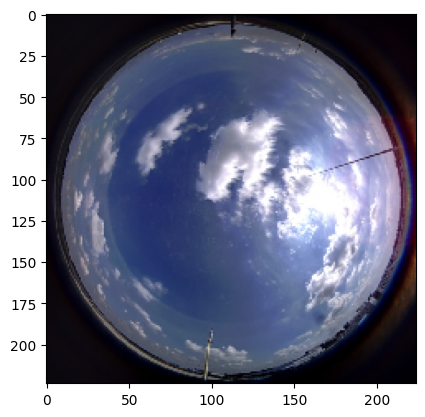

In [ ]:
plt.imshow(train_images[0])

In [ ]:
train_masks = []

for file in tqdm(sorted(os.listdir(mask_path))):
  filename = mask_path + file
  img = cv2.imread(filename)
  img = cv2.resize(img, (SIZE_X, SIZE_Y), 0, 0, interpolation = cv2.INTER_NEAREST)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  train_masks.append(img)
  # print(np.unique(np.array(img)))

train_masks = np.array(train_masks)

  0%|          | 0/1600 [00:00<?, ?it/s]

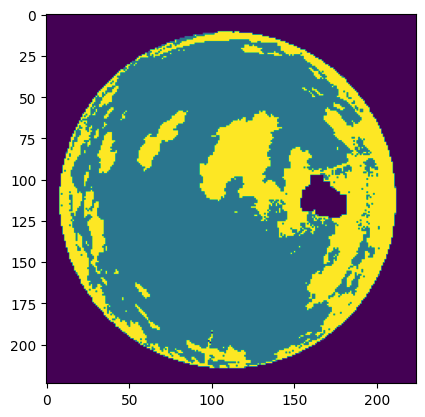

In [ ]:
plt.imshow(train_masks[0])

In [ ]:
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1, 1)
train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
train_masks_encoded_original_shape = train_masks_reshaped_encoded.reshape(n, h, w)

np.unique(train_masks_encoded_original_shape)

/usr/local/lib/python3.9/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array([0, 1, 2])

In [ ]:
len(np.unique(train_masks_encoded_original_shape))

3

In [ ]:
train_masks_input = np.expand_dims(train_masks_encoded_original_shape, axis=3)

#### Train/Test Split

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_images, train_masks_input, test_size=0.2, random_state = 42)
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3, random_state = 0)
print("Class values in the dataset are ...", np.unique(y_val))

Class values in the dataset are ... [0 1 2]


In [ ]:
print("Train set:", X_train.shape[0])
print("Validation set:", X_val.shape[0])
print("Test set:", X_test.shape[0])

Train set: 1280
Validation set: 224
Test set: 96


In [ ]:
train_masks_cat = to_categorical(y_train, num_classes=n_classes)
y_train_cat = train_masks_cat.reshape((y_train.shape[0], y_train.shape[1], y_train.shape[2], n_classes))

In [ ]:
test_masks_cat = to_categorical(y_test, num_classes=n_classes)
y_test_cat = test_masks_cat.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2], n_classes))

In [ ]:
test_masks_cat = to_categorical(y_val, num_classes=n_classes)
y_val_cat = test_masks_cat.reshape((y_val.shape[0], y_val.shape[1], y_val.shape[2], n_classes))

In [ ]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)

224
224
3


### Build U-NET multi-class model using pre-trained

In [ ]:
def jacard_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
metrics=['accuracy', jacard_coef]

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
# preprocess input
X_train_prepr = preprocess_input(X_train)
X_val_prepr = preprocess_input(X_val)
X_test_prepr = preprocess_input(X_test)

In [ ]:
model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation='softmax', encoder_freeze=True)

In [ ]:
!pip install tf-nightly

In [ ]:
opt = tf.keras.optimizers.Lion(learning_rate=1e-4)
model_resnet_backbone.compile(optimizer=opt, loss='categorical_crossentropy', metrics=metrics)

In [ ]:
model_resnet_backbone.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 data (InputLayer)           [(None, None, None, 3)]      0         []                            
                                                                                                  
 bn_data (BatchNormalizatio  (None, None, None, 3)        9         ['data[0][0]']                
 n)                                                                                               
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, None, None, 3)        0         ['bn_data[0][0]']             
 g2D)                                                                                             
                                                                                            

In [ ]:
history = model_resnet_backbone.fit(X_train_prepr, y_train_cat, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=60, 
                    validation_data=(X_val_prepr, y_val_cat), 
                    #class_weight=class_weights,
                    shuffle=False)

Epoch 1/60
40/40 [==============================] - 33s 374ms/step - loss: 0.6575 - accuracy: 0.7360 - jacard_coef: 0.4282 - val_loss: 1.0583 - val_accuracy: 0.4009 - val_jacard_coef: 0.2169
Epoch 2/60
40/40 [==============================] - 14s 340ms/step - loss: 0.3349 - accuracy: 0.9027 - jacard_coef: 0.6225 - val_loss: 0.9330 - val_accuracy: 0.5524 - val_jacard_coef: 0.3117
Epoch 3/60
40/40 [==============================] - 14s 342ms/step - loss: 0.2322 - accuracy: 0.9314 - jacard_coef: 0.7285 - val_loss: 1.2182 - val_accuracy: 0.5472 - val_jacard_coef: 0.3464
Epoch 4/60
40/40 [==============================] - 14s 348ms/step - loss: 0.1824 - accuracy: 0.9398 - jacard_coef: 0.7929 - val_loss: 1.5465 - val_accuracy: 0.5224 - val_jacard_coef: 0.3462
Epoch 5/60
40/40 [==============================] - 14s 346ms/step - loss: 0.1533 - accuracy: 0.9456 - jacard_coef: 0.8270 - val_loss: 1.9570 - val_accuracy: 0.5273 - val_jacard_coef: 0.3528
Epoch 6/60
40/40 [===========================

In [ ]:
loss, acc, jacard_coef  = model_resnet_backbone.evaluate(X_test, y_test_cat)
print("Loss : ", loss)
print("Accuracy : ", (acc * 100.0), "%")
print("Jacard coef : ", (jacard_coef * 100.0), "%")

3/3 [==============================] - 0s 121ms/step - loss: 0.0715 - accuracy: 0.9741 - jacard_coef: 0.9359
Loss :  0.07153929024934769
Accuracy :  97.40957617759705 %
Jacard coef :  93.58531832695007 %


In [ ]:
# model_resnet_backbone.save('/content/drive/MyDrive/senior/cloud segmentations/cloudSeg_model/cloud-seg-resnet34-adw-60-1e_4-fine_tune10.h5')
model_json = model_resnet_backbone.to_json()
with open("/content/drive/MyDrive/senior/cloud segmentations/cloudSeg_model/json-cloud-seg-resnet34-aug-lion-60-1e_4.json", "w") as json_file:
  json_file.write(model_json)

model_resnet_backbone.save_weights('/content/drive/MyDrive/senior/cloud segmentations/cloudSeg_model/weight-cloud-seg-resnet34-aug-lion-60-1e_4.h5')
model_resnet_backbone.save('/content/drive/MyDrive/senior/cloud segmentations/cloudSeg_model/model-cloud-seg-resnet34-aug-lion-60-1e_4..keras')

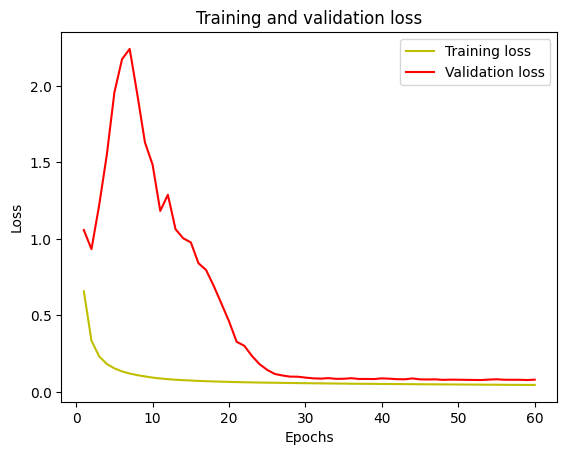

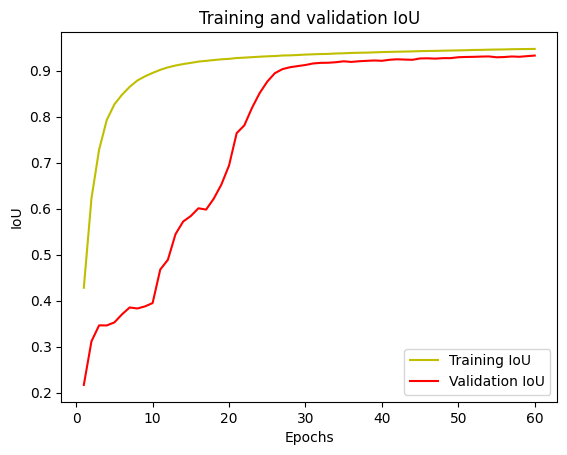

Training loss:  0.04519328474998474
Validation loss:  0.07959391176700592
Training accuracy:  0.9475129246711731
Validation accuracy:  0.933071494102478


In [ ]:
###
#plot the training and validation accuracy and loss at each epoch
# plt.figure(figsize=(12, 8))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['jacard_coef']
val_acc = history.history['val_jacard_coef']

plt.plot(epochs, acc, 'y', label='Training IoU')
plt.plot(epochs, val_acc, 'r', label='Validation IoU')
plt.title('Training and validation IoU')
plt.xlabel('Epochs')
plt.ylabel('IoU')
plt.legend()
plt.show()

print("Training loss: ",loss[-1])
print("Validation loss: ",val_loss[-1])
print("Training accuracy: ",acc[-1])
print("Validation accuracy: ",val_acc[-1])

In [ ]:
#IOU
y_pred=model_resnet_backbone.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

3/3 [==============================] - 1s 110ms/step


In [ ]:
from keras.metrics import MeanIoU
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.94782835


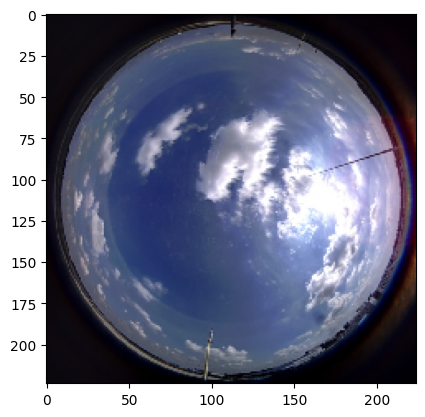

In [ ]:
plt.imshow(train_images[0])

In [ ]:
import random
test_img_number = random.randint(0, len(X_test))
print("Random index: ",test_img_number)
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_input=np.expand_dims(test_img, 0)
prediction = (model_resnet_backbone.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

Random index:  20
1/1 [==============================] - 1s 1s/step


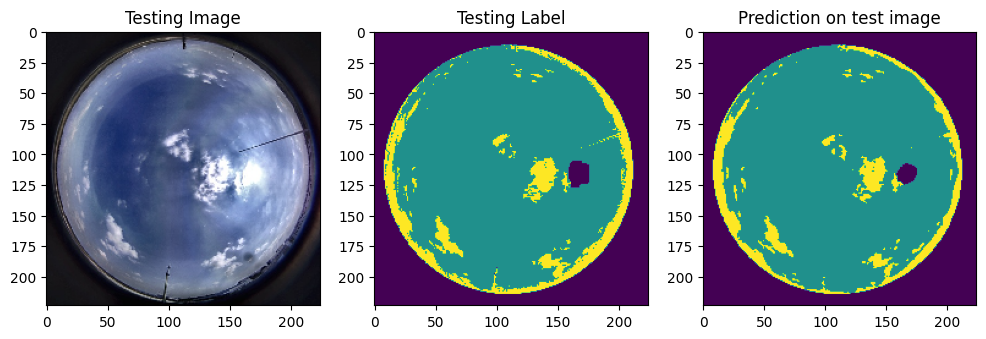

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

Before resize: (1170, 1170, 3)
After resize: (224, 224, 3)


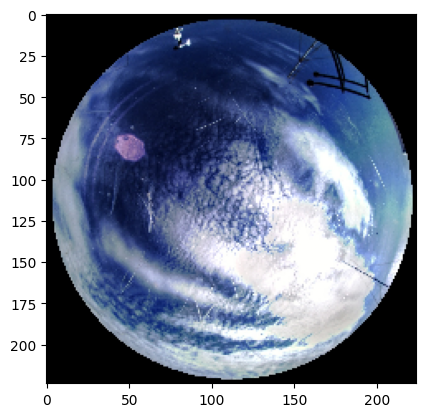

In [ ]:
from cv2 import dnn_superres

local_path = "/content/drive/MyDrive/senior/cloud segmentations/2021_11_25__10_00_00_crop2.jpg"
test_local_img = cv2.imread(local_path)
print("Before resize:",test_local_img.shape)
test_local_img = cv2.resize(test_local_img, (SIZE_X, SIZE_Y), interpolation = cv2.INTER_NEAREST)
test_local_img = cv2.cvtColor(test_local_img, cv2.COLOR_BGR2RGB)
test_local_img = test_local_img/255.0
print("After resize:",test_local_img.shape)

### circle crop --- If use _cropped_2 not use crop function
# r1 = test_local_img.shape[1]
# r2 = test_local_img.shape[0]
# mask = np.zeros((r2, r1), dtype=np.uint8)
# cv2.circle(mask, (int(r1/2), int(r2/2)), 102, (255, 255, 255), -1, 8, 0)
# masked = cv2.bitwise_and(test_local_img, test_local_img, mask=mask)

### super resolution
# sr = dnn_superres.DnnSuperResImpl_create()
# path = "/content/drive/MyDrive/Connected_Project/EDSR_Tensorflow/models/EDSR_x4.pb"
# sr.readModel(path)

# # Set the desired model and scale to get correct pre- and post-processing
# sr.setModel("edsr", 4)
# sr.setPreferableBackend(cv2.dnn.DNN_BACKEND_CUDA)
# sr.setPreferableTarget(cv2.dnn.DNN_TARGET_CUDA)
# masked = test_local_img
# masked = sr.upsample(masked)
masked = test_local_img
plt.imshow(masked)

1/1 [==============================] - 0s 25ms/step


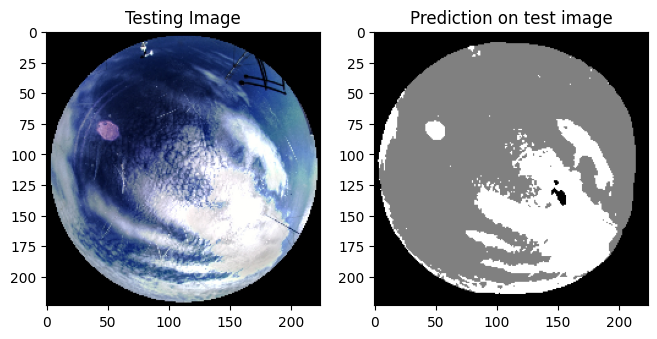

In [ ]:
local_test_img_input=np.expand_dims(masked, 0)
prediction_local = (model_resnet_backbone.predict(local_test_img_input))
local_predicted_img=np.argmax(prediction_local, axis=3)[0,:,:]

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(masked)
plt.subplot(232)
plt.title('Prediction on test image')
plt.imshow(local_predicted_img, cmap="gray")
plt.show()

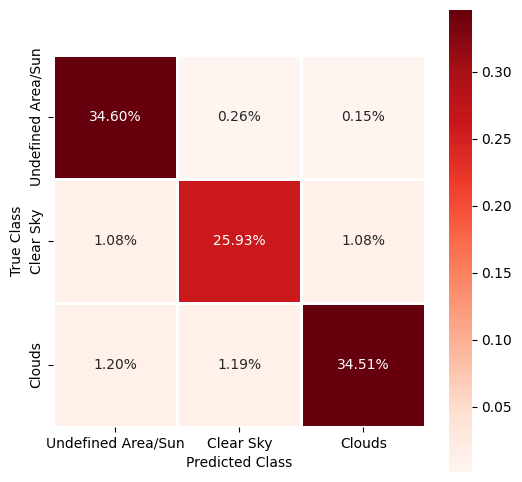

In [ ]:
import seaborn as sns

# Define the class names
class_names = ["Undefined Area/Sun", "Clear Sky", "Clouds"]

# Create a 3x3 matrix to hold the number of true positives, false positives, false negatives, and true negatives for each class
TP = [0]*3
FP = [0]*3
FN = [0]*3
TN = [0]*3

# Calculate the number of true positives, false positives, false negatives, and true negatives for each class
for i in range(3):
    FP[i] = len(np.where((y_pred_argmax == i) & (y_test[:,:,:,0] != i))[0])
    FN[i] = len(np.where((y_pred_argmax != i) & (y_test[:,:,:,0] == i))[0])
    TP[i] = len(np.where((y_pred_argmax == i) & (y_test[:,:,:,0] == i))[0])
    TN[i] = len(np.where((y_pred_argmax != i) & (y_test[:,:,:,0] != i))[0])

# Create the confusion matrix
cmat = [[TP[0], FN[0], FP[0]], [FN[1], TP[1], FN[1]], [FP[2], FN[2], TP[2]]]

plt.figure(figsize = (6,6))
sns.heatmap(cmat/np.sum(cmat), cmap="Reds", annot=True, fmt = '.2%', square=1, linewidth=2., xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.show()
